### Ensemble models

Installing python libraries

In [1]:
!pip install matplotlib numpy pandas scikit-learn dask seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Importing python libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Getting the dataset

In [ ]:
dataset = '../Datasets/Small_datasetPreprocessed.parquet'

if os.path.exists(dataset):
    df = pd.read_parquet(dataset)
    df = df.dropna()
else:
    print("Dataset not found")

Training

In [4]:
# Define train, test, validation sets
X = df.drop(['total_amount'], axis=1)
y = df['total_amount']

print(df.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

   vendorid  passenger_count  trip_distance  ratecodeid  total_amount  \
0       2.0              1.0           0.52         1.0           5.3   
1       2.0              1.0           1.15         1.0           7.8   
2       2.0              1.0           2.44         1.0          12.3   
3       1.0              1.0           1.20         1.0           6.3   
4       1.0              1.0           4.60         1.0          20.8   

   pickup_hour  time_in_taxi  tavg  precipitation  new_snow  snow_depth  \
0            9      3.616667  71.5            0.0       0.0         0.0   
1            7      7.983333  17.0            0.0       0.0         0.0   
2           15     11.250000  77.5            0.0       0.0         0.0   
3            6      3.400000  71.5            0.0       0.0         0.0   
4            8     24.216667  30.0            0.0       0.0         0.0   

   day_type  service_zone_pulocation  service_zone_dolocation  
0         1                      3.0          

Functions to plot the models results

In [16]:
def plot_grid_search_heatmap(grid_search, param1, param2, metric="mean_test_score"):
    results = grid_search.cv_results_
    scores = results[metric].reshape(len(grid_search.param_grid[param1]), len(grid_search.param_grid[param2]))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(scores, annot=True, fmt=".3f", xticklabels=grid_search.param_grid[param2],
                yticklabels=grid_search.param_grid[param1], cmap="viridis")
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.title(f"GridSearch Heatmap")
    plt.show()

def plot_predictions_vs_true(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6, color="blue", label="Predictions")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color="red", linestyle="--", label="Ideal Fit")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name}: Predictions vs True Values")
    plt.legend()
    plt.grid()
    plt.show()

def plot_model_comparison(models, metrics):
    # Bar chart parameters
    metric_labels = ["MSE", "MAE", "R2"]
    colors = ['#FFEA00', '#FFC300', '#FF9A00', '#FF7300', '#FF4C00', '#E63900', '#CC2900']
    x = np.arange(len(metric_labels))  # the label locations
    width = 0.2  # width of each bar

    # Create the plot
    _, ax = plt.subplots(figsize=(10, 6))

    # Add bars for each model
    for i, model in enumerate(models):
        metric_values = [metrics[0][i], metrics[1][i], metrics[2][i]]
        bars = ax.bar(x + i * width, metric_values, width, label=model, color=colors[i*2])
        
        # Add value labels on top of each bar
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.2f}", ha="center", va="bottom", fontsize=14)

    # Add labels, title, and legend
    ax.set_xlabel('Metrics', fontsize=16)
    ax.set_ylabel('Metric Values', fontsize=16)
    ax.set_title('Ensemble Models Performance', fontsize=18)
    ax.set_xticks(x + (width * (len(models) - 1) / 2))  # Center x-ticks under groups
    ax.set_xticklabels(metric_labels, fontsize=14)
    ax.legend(title="Models", title_fontsize=16, fontsize=14)

    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.show()


Random Forest Regressor ensemble model with grid search for the best parameters

Best Parameters: {'max_features': 5, 'n_estimators': 50}
Best R^2 Score: 0.9774438350051214


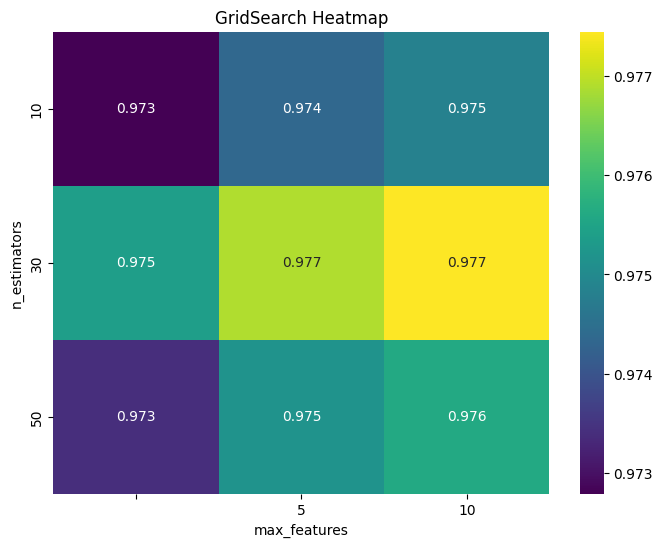

In [6]:
param_grid = {
    'n_estimators': [10, 30, 50],
    'max_features': [None, 5, 10],
}
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_val, y_val)

print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

plot_grid_search_heatmap(grid_search, "n_estimators", "max_features")

Mean Squared Error: 1.2547014653742017
Mean Absolute Error: 0.5408531004920765
R^2 Score: 0.9806324732868973


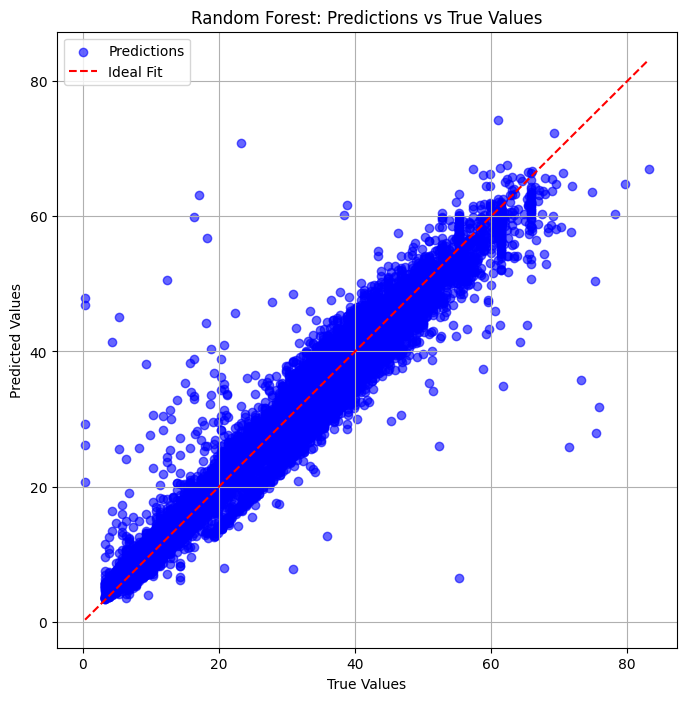

In [7]:
bagging_rf = RandomForestRegressor(n_estimators=50, max_features=5, random_state=42)
bagging_rf.fit(X_train, y_train)

y_pred = bagging_rf.predict(X_test)

mse_random_forest = mean_squared_error(y_test, y_pred)
mae_random_forest = mean_absolute_error(y_test, y_pred)
r2_random_forest = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_random_forest)
print("Mean Absolute Error:", mae_random_forest)
print("R^2 Score:", r2_random_forest)

plot_predictions_vs_true(y_test, y_pred, "Random Forest")

AdaBoost Regressor ensemble model with grid search for the best parameters

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best R^2 Score: 0.8731830442452649


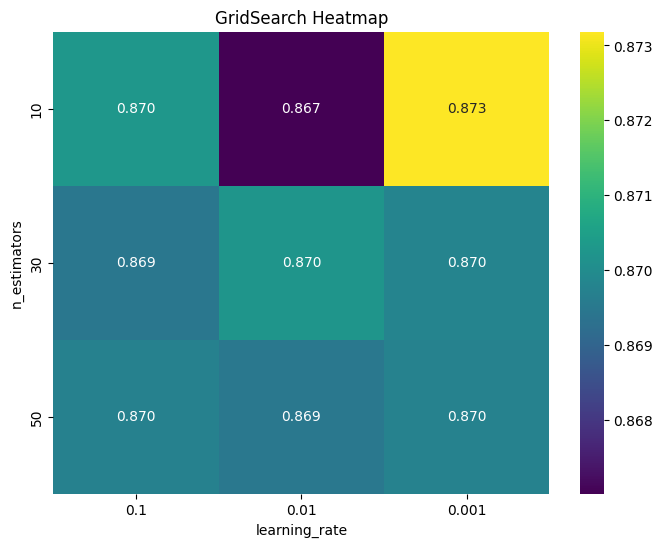

In [8]:
param_grid = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.01, 0.001],
}
grid_search = GridSearchCV(
    estimator=AdaBoostRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_val, y_val)

print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

plot_grid_search_heatmap(grid_search, "n_estimators", "learning_rate")

Mean Squared Error: 8.866032781481572
Mean Absolute Error: 2.1621193395774445
R^2 Score: 0.8631442367181923


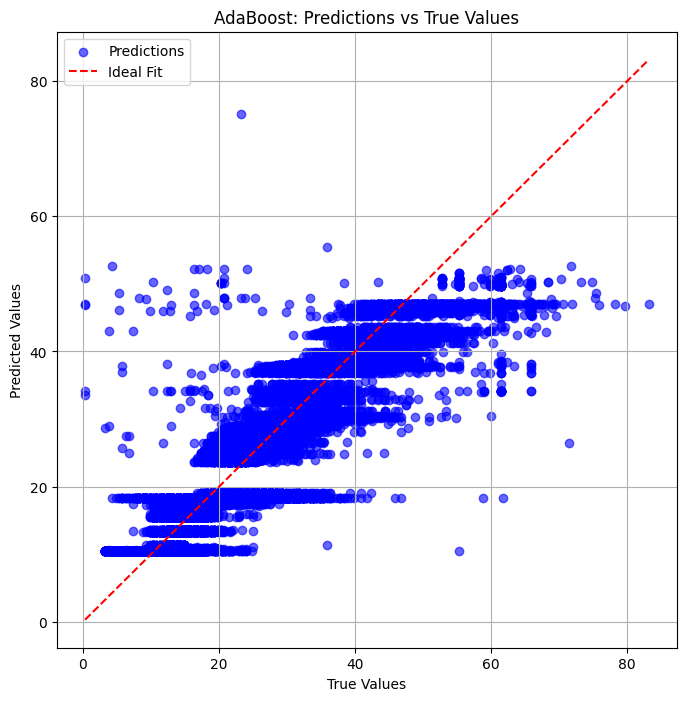

In [9]:
boosting_ada = AdaBoostRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
boosting_ada.fit(X_train, y_train)

y_pred = boosting_ada.predict(X_test)

mse_adaboost = mean_squared_error(y_test, y_pred)
mae_adaboost = mean_absolute_error(y_test, y_pred)
r2_adaboost = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_adaboost)
print("Mean Absolute Error:", mae_adaboost)
print("R^2 Score:", r2_adaboost)

plot_predictions_vs_true(y_test, y_pred, "AdaBoost")

Gradient Boosting Regressor ensemble model with grid search for the best parameters

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best R^2 Score: 0.9658822007000708


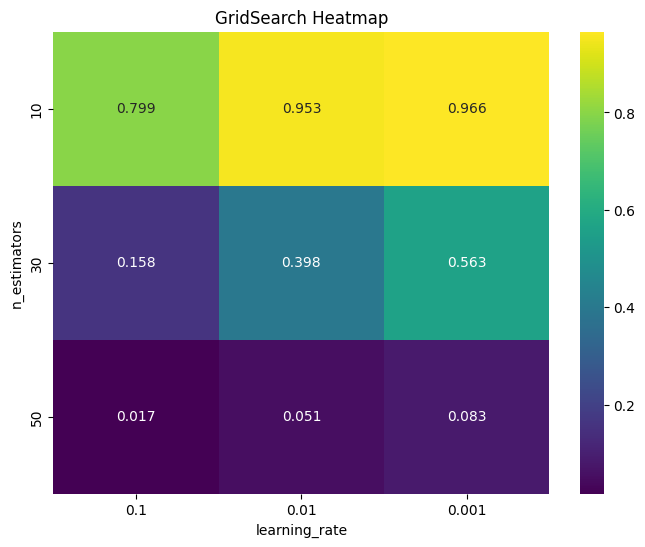

In [10]:
param_grid = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.01, 0.001],
}
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_val, y_val)

print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

plot_grid_search_heatmap(grid_search, "n_estimators", "learning_rate")

Mean Squared Error: 2.202620393506344
Mean Absolute Error: 0.8144459689833952
R^2 Score: 0.9660004307898562


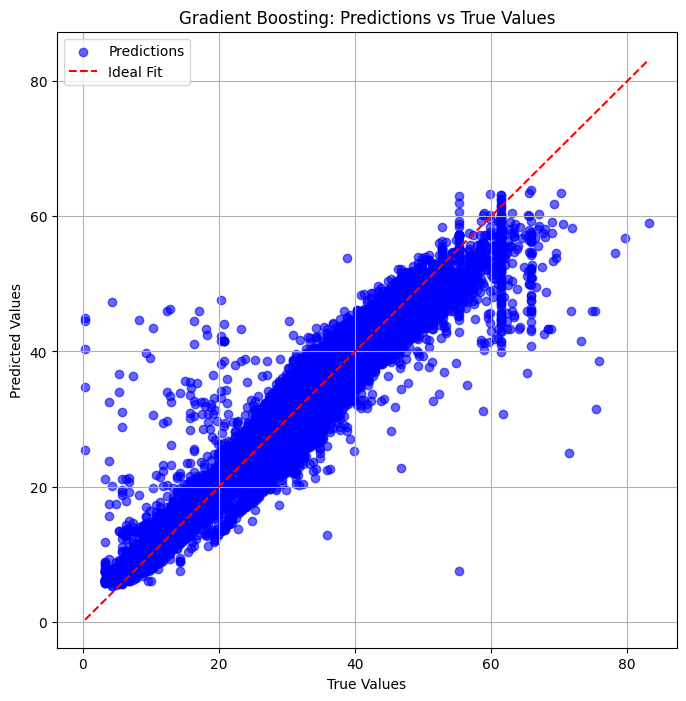

In [11]:
boosting_grad = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
boosting_grad.fit(X_train, y_train)

y_pred = boosting_grad.predict(X_test)

mse_gradboost = mean_squared_error(y_test, y_pred)
mae_gradboost = mean_absolute_error(y_test, y_pred)
r2_gradboost = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_gradboost)
print("Mean Absolute Error:", mae_gradboost)
print("R^2 Score:", r2_gradboost)

plot_predictions_vs_true(y_test, y_pred, "Gradient Boosting")

Stacking ensemble model

Mean Squared Error: 2.4406332553442067
Mean Absolute Error: 0.7622007177259605
R^2 Score: 0.9623264728110695


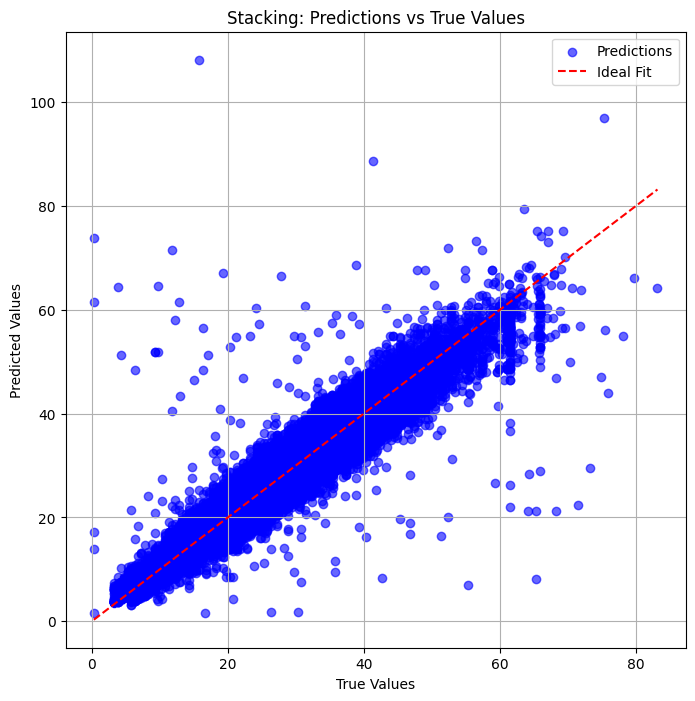

In [12]:
# Define the base and meta models
base_learners = [
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('el', ElasticNet(alpha=0.1, l1_ratio=0.5))
]
meta_model = LinearRegression()

stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_model
)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

mse_stacking = mean_squared_error(y_test, y_pred)
mae_stacking = mean_absolute_error(y_test, y_pred)
r2_stacking = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_stacking)
print("Mean Absolute Error:", mae_stacking)
print("R^2 Score:", r2_stacking)

plot_predictions_vs_true(y_test, y_pred, "Stacking")

Models evaluation

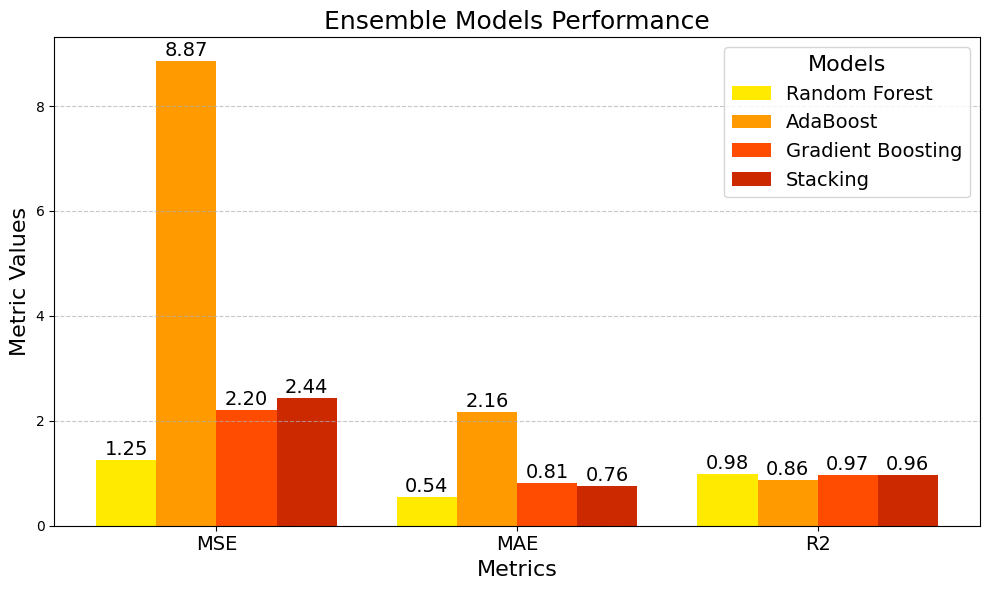

In [17]:
models = ["Random Forest", "AdaBoost", "Gradient Boosting", "Stacking"]
metrics_mse = [mse_random_forest, mse_adaboost, mse_gradboost, mse_stacking]
metrics_mae = [mae_random_forest, mae_adaboost, mae_gradboost, mae_stacking]
metrics_r2 = [r2_random_forest, r2_adaboost, r2_gradboost, r2_stacking]
metrics = [metrics_mse, metrics_mae, metrics_r2]
plot_model_comparison(models, metrics)